# 1. 创建数据软连接

In [2]:
import os
from random import shuffle
import shutil
import numpy as np
from collections import defaultdict
#seed 
np.random.seed(2018)
#对五类图片进行软连接处理
source_dir1 = '/home/mxq/Jupyter/Keras/cifar_5/data/train'
#target_dir = '/home/mxq/Jupyter/Keras/dogsvscats/data/train_sym'
source_dir2 = '/home/mxq/Jupyter/Keras/cifar_5/data/validation'

#target_dir = '/home/mxq/Jupyter/Keras/dogsvscats/5_classes_data/train_sym'
target_dir = '/home/mxq/Jupyter/Keras/cifar_5/data/validation_sym'

def datadivide():
    samples,classes = generate_valid_imagepaths(source_dir2)
    for _ in classes.items():
        #shuffle(_[1])
        #classes[_[0]] = _[1][2000:2500]
        pass
    dothings(classes)
    print('done')
def dothings(classes):
    for class_path in classes.items():
        sub_dir = os.path.join(target_dir,class_path[0])
        if os.path.exists(sub_dir):
            shutil.rmtree(sub_dir)
        os.mkdir(sub_dir)
        filepaths = class_path[1]
        symlink_img(filepaths,sub_dir)

def symlink_img(filepaths,target_dir):
    for source_filepath in filepaths:
        symfilepath = os.path.split(source_filepath)[-1]
        target_filepath = os.path.join(target_dir,symfilepath)
        os.symlink(source_filepath,target_filepath)
    
def generate_valid_imagepaths(directory,follow_links=False):
    
    def _recursive_list(subpath):
        return sorted(os.walk(subpath,followlinks=follow_links),key=lambda tpl:tpl[0])
    samples = 0
    classes_file = defaultdict(list)
    for dirpath, _, files in _recursive_list(directory):
        #for fname in sorted(files,key=lambda s:int(s[4:-4])):
        for fname in sorted(files):
            if fname[:1] == '3':
               filepath = os.path.join(dirpath, fname)
               classes_file['bus'].append(filepath)
               samples += 1
            elif fname[:1] == '4':
                filepath = os.path.join(dirpath, fname)
                classes_file['dinosaurs'].append(filepath)
                samples += 1
            elif fname[:1] == '5':
                filepath = os.path.join(dirpath, fname)
                classes_file['elephants'].append(filepath)
                samples += 1
            elif fname[:1] == '6':
                filepath = os.path.join(dirpath, fname)
                classes_file['flowers'].append(filepath)
                samples += 1
            else:
                filepath = os.path.join(dirpath, fname)
                classes_file['horse'].append(filepath)
                samples += 1
    return samples,classes_file
if __name__ == '__main__':
    datadivide()


done


# 2. 导入所需库

In [1]:
import os
import sys
import argparse
import matplotlib.pyplot as plt

from keras import __version__
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

print('import done')


Using TensorFlow backend.


import done


# 3.数据准备

In [5]:

IM_WIDTH,IM_HEIGHT = 299 , 299
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172
batch_size = 16
train_dir = 'data/train_sym'
val_dir = 'data/validation_sym'

train_datagen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                rotation_range=30,
                width_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)


test_datagen = ImageDataGenerator(
                preprocessing_function=preprocess_input,
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)
# 训练数据与测试数据

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(IM_WIDTH,IM_HEIGHT),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
                                                    val_dir,
                                                    target_size=(IM_WIDTH,IM_HEIGHT),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


# 4. fine-tuning方式一:使用预训练网络的bottleneck特征

In [4]:
#添加新层
def add_new_last_layer(base_model,nb_classes):
    '''
      添加最后的层
      输入:base_model和分类数目
      输出:新的keras的model
    '''
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE,activation='relu')(x)#new FC layer,random init
    predictions = Dense(nb_classes,activation='softmax')(x)
    model = Model(input=base_model.input,output=predictions)
    
    return model

#冻上base_model所有层,这样就可以正确获得bottleneck特征

def setup_to_transfer_learn(model,base_model):
    '''freeze all layers and compile '''
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    
#定义网络框架
nb_classes = 5
base_model = InceptionV3(weights='imagenet',include_top=False)
model = add_new_last_layer(base_model,nb_classes)
setup_to_transfer_learn(model,base_model)

#模式一训练
histroy_tl = model.fit_generator(
            train_generator,
            nb_epoch=3,
            samples_per_epoch=400,
            validation_data=validation_generator,
            nb_val_samples=100,
            class_weight='auto')
    
    
    

/home/mxq/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/home/mxq/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/mxq/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., class_weight="auto", validation_steps=100, epochs=3, validation_data=<keras.pre..., steps_per_ep

Epoch 1/3
25/25 [==============================] - 522s 21s/step - loss: 2.7114 - acc: 0.6300 - val_loss: 0.0526 - val_acc: 0.9895
Epoch 2/3
25/25 [==============================] - 498s 20s/step - loss: 0.2256 - acc: 0.9325 - val_loss: 0.0061 - val_acc: 0.9986
Epoch 3/3
25/25 [==============================] - 697s 28s/step - loss: 0.4980 - acc: 0.8950 - val_loss: 0.0146 - val_acc: 0.9965


# 5.fine-tuning方式二：要调整权重，并训练

In [11]:
# 冻上NB_IV3_LAYERS之前的层
NB_IV3_LAYERS_TO_FREEZE = 172
def setup_to_finetune(model):
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),loss='categorical_crossentropy', metrics=['accuracy'])

#设置网格结构
setup_to_finetune(model)

#模式二训练
history_ft = model.fit_generator(
train_generator,
samples_per_epoch=400,
nb_epoch=3,
validation_data=validation_generator,
nb_val_samples=100,
class_weight='auto')

# 模型保存
model.save('fine-tuning.h5')

/home/mxq/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/mxq/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., class_weight="auto", validation_steps=100, epochs=3, validation_data=<keras.pre..., steps_per_epoch=25)`


Epoch 1/3
25/25 [==============================] - 807s 32s/step - loss: 0.1471 - acc: 0.9550 - val_loss: 0.0277 - val_acc: 0.9958
Epoch 2/3
25/25 [==============================] - 793s 32s/step - loss: 0.1025 - acc: 0.9675 - val_loss: 0.0235 - val_acc: 0.9930
Epoch 3/3
25/25 [==============================] - 767s 31s/step - loss: 0.0347 - acc: 0.9950 - val_loss: 0.0165 - val_acc: 0.9958


# 6.画图函数

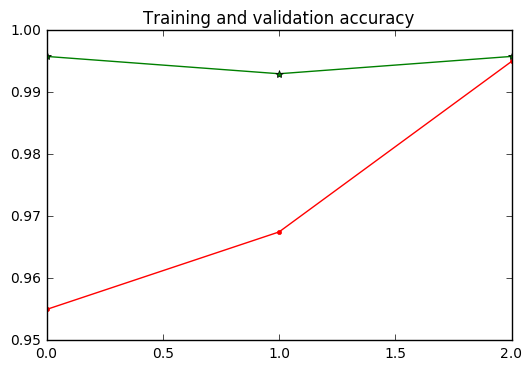

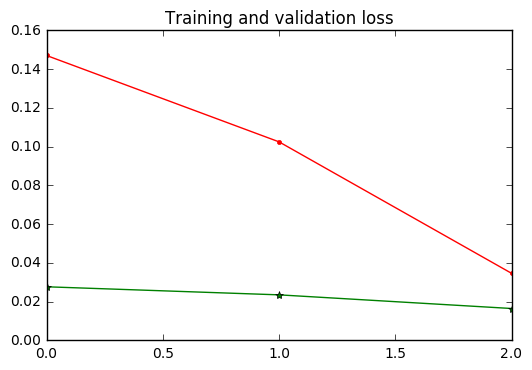

In [26]:
%matplotlib inline
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoches = range(len(acc))
    plt.plot(epoches,acc,'-r.')
    plt.plot(epoches,val_acc,'-g*')
    plt.title('Training and validation accuracy')
    plt.figure()
    plt.plot(epoches,loss,'-r.')
    plt.plot(epoches,val_loss,'-g*')
    plt.title('Training and validation loss')
    plt.show()

plot_training(history_ft)

# 7. 预测

In [2]:
from keras.models import load_model
model_pred = load_model('fine-tuning.h5')
print('model load done !')

model load done !


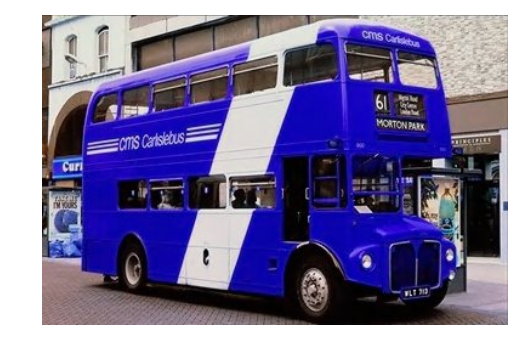

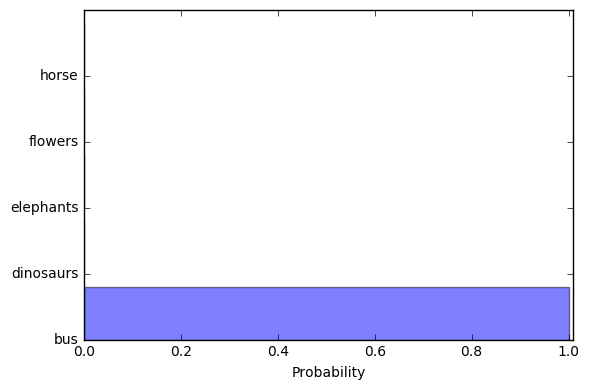

"from skimage import io\nimage_url = 'http://image.baidu.com/search/detail?ct=503316480&z=undefined&tn=baiduimagedetail&ipn=d&word=%E6%B1%BD%E8%BD%A6&step_word=&ie=utf-8&in=&cl=2&lm=-1&st=undefined&cs=783060973,4278100629&os=3297547840,3597729277&simid=3523206177,148915200&pn=0&rn=1&di=38631860080&ln=1993&fr=&fmq=1519812059733_R&fm=&ic=undefined&s=undefined&se=&sme=&tab=0&width=undefined&height=undefined&face=undefined&is=0,0&istype=0&ist=&jit=&bdtype=0&spn=0&pi=0&gsm=0&objurl=http%3A%2F%2Fpic7.nipic.com%2F20100518%2F3409334_031036048098_2.jpg&rpstart=0&rpnum=0&adpicid=0'\nimg = image.load_img(image_url)\npreds = predict(model, img, target_size)\nimage =cv2.imread(image_url)\nimage = io.imread(image_url)\nplot_preds(image, preds)\n"

In [17]:
%matplotlib inline
# 定义层
import sys
import argparse
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import cv2  
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

# 狂阶图片指定尺寸
target_size = (229, 229) #fixed size for InceptionV3 architecture

# 预测函数
# 输入：model，图片，目标尺寸
# 输出：预测predict
def predict(model, img, target_size):
  """Run model prediction on image
  Args:
    model: keras model
    img: PIL format image
    target_size: (w,h) tuple
  Returns:
    list of predicted labels and their probabilities
  """
  if img.size != target_size:
    img = img.resize(target_size)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  return preds[0]

# 画图函数
# 预测之后画图，这里默认是猫狗，当然可以修改label

labels = ("bus", "dinosaurs","elephants","flowers","horse")
def plot_preds(image_local, preds):
  image =cv2.imread(image_local)
  plt.imshow(image)
  plt.axis('off')
  plt.figure()
  plt.barh([0,1,2,3,4], preds, alpha=0.5)
  plt.yticks([0,1,2,3,4], labels)
  plt.xlabel('Probability')
  plt.xlim(0,1.01)
  plt.tight_layout()
  plt.show()

# 载入模型
model = model_pred

# 本地图片
image_local = 'data/train_sym/bus/320.jpg'
#image_local = 'data/test/ele.jpeg'
img = image.load_img(image_local)

preds = predict(model, img, target_size)

plot_preds(image_local, preds)

# 图片URL
'''from skimage import io
image_url = 'http://image.baidu.com/search/detail?ct=503316480&z=undefined&tn=baiduimagedetail&ipn=d&word=%E6%B1%BD%E8%BD%A6&step_word=&ie=utf-8&in=&cl=2&lm=-1&st=undefined&cs=783060973,4278100629&os=3297547840,3597729277&simid=3523206177,148915200&pn=0&rn=1&di=38631860080&ln=1993&fr=&fmq=1519812059733_R&fm=&ic=undefined&s=undefined&se=&sme=&tab=0&width=undefined&height=undefined&face=undefined&is=0,0&istype=0&ist=&jit=&bdtype=0&spn=0&pi=0&gsm=0&objurl=http%3A%2F%2Fpic7.nipic.com%2F20100518%2F3409334_031036048098_2.jpg&rpstart=0&rpnum=0&adpicid=0'
img = image.load_img(image_url)
preds = predict(model, img, target_size)
image =cv2.imread(image_url)
image = io.imread(image_url)
plot_preds(image, preds)
'''

#preds = predict(model, img, target_size)
#plot_preds(img, preds)